# 3D, STL, OBJ & Stuff

In [52]:
import json

import sdf

## Snippets

### Simple STL files (Discovery)

- [ ] Simplex
- [ ] Pyramid
- [ ] Explore qwirks: repr of outer faces, normals maybe not used, right-hand side rule, etc.




In [1]:
facet = """
facet normal {n[0]} {n[1]} {n[2]}
    outer loop
        vertex {t[0][0]} {t[0][1]} {t[0][2]}
        vertex {t[1][0]} {t[1][1]} {t[1][2]}
        vertex {t[2][0]} {t[2][1]} {t[2][2]}
    endloop
endfacet
"""

In [2]:
import numpy as np
normal = np.array([1.0, 1.0, 1.0], dtype=np.float32)
normal /= np.linalg.norm(normal)
normal

array([0.57735026, 0.57735026, 0.57735026], dtype=float32)

In [3]:
triangle = np.array([
    [1.0, 0.0, 0.0], 
    [0.0, 1.0, 0.0], 
    [0.0, 0.0, 1.0],
], dtype=np.float32)

In [4]:
print(facet.format(n=normal, t=triangle))


facet normal 0.5773502588272095 0.5773502588272095 0.5773502588272095
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet



In [5]:
name = "simplex"

solid = f"""
solid {name}

{facet.format(n=normal, t=triangle)}

endsolid {name}
"""

print(solid)


solid simplex


facet normal 0.5773502588272095 0.5773502588272095 0.5773502588272095
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet


endsolid simplex



In [6]:
with open(f"sandbox/{name}.stl", mode="wt") as file:
    file.write(solid)

In [7]:
name = "simplex"

solid = f"""
solid {name}

{facet.format(n=-normal, t=triangle)}

endsolid {name}
"""

print(solid)


solid simplex


facet normal -0.5773502588272095 -0.5773502588272095 -0.5773502588272095
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet


endsolid simplex



In [8]:
name = "simplex-opposite-normal"
with open(f"sandbox/{name}.stl", mode="wt") as file:
    file.write(solid)

In [9]:
normal = np.array([12.0, -56.0, 456.0], dtype=np.float32)

name = "simplex"

solid = f"""
solid {name}

{facet.format(n=normal, t=triangle)}

endsolid {name}
"""

print(solid)


name = "simplex-random-normal"
with open(f"sandbox/{name}.stl", mode="wt") as file:
    file.write(solid)


solid simplex


facet normal 12.0 -56.0 456.0
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet


endsolid simplex



In [10]:
normal = np.array([0.0, 0.0, 0.0], dtype=np.float32)

name = "simplex"

solid = f"""
solid {name}

{facet.format(n=normal, t=triangle)}

endsolid {name}
"""

print(solid)


name = "simplex-zero-normal"
with open(f"sandbox/{name}.stl", mode="wt") as file:
    file.write(solid)


solid simplex


facet normal 0.0 0.0 0.0
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet


endsolid simplex



**TODO** warning about the behavior of the readers wrt normals and outer/inner representation.
Inner may be displayed as outer or not at all and the normal may not be used.

AFAICT the GitHub viewer will:

- discard the normal info when it comes to determine the normal (use orientation instead)

- only display the outer face

- BUT, display this face is black when the normal in the file does not match its computation.

YMML


In [11]:
import numpy as np
normal = np.array([1.0, 1.0, 1.0], dtype=np.float32)
normal /= np.linalg.norm(normal)

triangle = np.array([
    [1.0, 0.0, 0.0], 
    [0.0, 1.0, 0.0], 
    [0.0, 0.0, 1.0],
], dtype=np.float32)

R = np.array([
    [0.0, -1.0, 0.0],
    [1.0,  0.0, 0.0],
    [0.0,  0.0, 1.0],
], dtype=np.float32)

with open("sandbox/pyramid.stl", mode="tw") as file:
    file.write("solid pyramid\n\n")
    for i in [0, 1, 2, 3]:
        file.write(facet.format(n=normal, t=triangle))
        normal = R @ normal
        triangle = triangle @ R.T
    file.write("endsolid pyramid\n")


## Getting Serious

- [ ] Make function (triangles, normals=None, name=None) -> STL string
- [ ] **TODO** Make STL (text) tokenizer + parser into triangles / normals array
- [ ] **TODO** Make "condition number" + "strict normal checker" (optionally rewriter)
- [ ] Obj to STL (**TODO**: make normals (opt.) + points + indices -> normals, triangles instead

#### Make STL from numpy data

In [12]:
import numpy as np

def make_STL(triangles, normals=None, name=""):
    triangles = np.array(triangles, dtype=np.float32)
    if normals is None:
        d1 = triangles[:,1,:] - triangles[:,0,:]
        d2 = triangles[:,2,:] - triangles[:,1,:]
        print(d1.shape)
        vector_product = np.linalg.cross(d1, d2)
        norms = np.linalg.norm(vector_product, axis=1)
        normals = np.diag(1 / norms) @ vector_product 
    out = f"solid {name}\n"
    for t, n in zip(triangles, normals):
        out += f"""
facet normal {n[0]} {n[1]} {n[2]}
    outer loop
        vertex {t[0][0]} {t[0][1]} {t[0][2]}
        vertex {t[1][0]} {t[1][1]} {t[1][2]}
        vertex {t[2][0]} {t[2][1]} {t[2][2]}
    endloop
endfacet
"""
    out += f"\nendsolid {name}\n"
    return out

In [13]:
import numpy as np
normals = np.array([1.0, 1.0, 1.0], dtype=np.float32)
normals /= np.linalg.norm(normals)
normals = np.array([normals], dtype=np.float32)

triangles = np.array([[
    [1.0, 0.0, 0.0], 
    [0.0, 1.0, 0.0], 
    [0.0, 0.0, 1.0],
]], dtype=np.float32)


out = make_STL(triangles, normals, name="simplex")
print(out)

solid simplex

facet normal 0.5773502588272095 0.5773502588272095 0.5773502588272095
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet

endsolid simplex



In [14]:
out = make_STL(triangles)
print(out)

(1, 3)
solid 

facet normal 0.5773502588272095 0.5773502588272095 0.5773502588272095
    outer loop
        vertex 1.0 0.0 0.0
        vertex 0.0 1.0 0.0
        vertex 0.0 0.0 1.0
    endloop
endfacet

endsolid 



#### Make STL (text) tokenizer + parser -> numpy data (drop name)


In [15]:
keywords = ["solid", "endsolid", "facet", "endfacet", "outer", "loop", "endloop", "vertex"]

def tokenize(STL_text):
    raw_tokens = STL_text.split()
    # turn numbers into float32
    # get rid of non-keywords names
    tokens = []
    for s in raw_tokens:
        try:
            tokens.append(np.float32(s))
        except ValueError:
            if s in keywords:
                tokens.append(s)
    return tokens

tokenize(out)


['solid',
 'facet',
 np.float32(0.57735026),
 np.float32(0.57735026),
 np.float32(0.57735026),
 'outer',
 'loop',
 'vertex',
 np.float32(1.0),
 np.float32(0.0),
 np.float32(0.0),
 'vertex',
 np.float32(0.0),
 np.float32(1.0),
 np.float32(0.0),
 'vertex',
 np.float32(0.0),
 np.float32(0.0),
 np.float32(1.0),
 'endloop',
 'endfacet',
 'endsolid']

In [16]:
def parse(tokens):
    normals = []
    for i, token in enumerate(tokens):
        if token == "facet":
            normals.append(np.array(tokens[i+1:i+4]))
    triangles = []
    for i, token in enumerate(tokens):
        if token == "loop":
            triangle = []
            triangle.append(np.array(tokens[i+2:i+5]))
            triangle.append(np.array(tokens[i+6:i+9]))
            triangle.append(np.array(tokens[i+10:i+13]))
            triangles.append(np.array(triangle))
    return np.array(triangles), np.array(normals)

In [17]:
parse(tokenize(out))

(array([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]], dtype=float32),
 array([[0.57735026, 0.57735026, 0.57735026]], dtype=float32))

#### Make "degenerate triangles" + “condition number” + “strict normal checker” (optionally rewriter)

**TODO**

#### Obj to STL

In [18]:
with open("data/bunny.obj", mode="tr") as file:
    bunny_obj = file.read()
lines = bunny_obj.splitlines()
for line in lines[:10]:
    print(line)
print("...")
for line in lines[-10:]:
    print(line)

# OBJ file format with ext .obj
# vertex count = 2503
# face count = 4968
v -3.4101800e-003 1.3031957e-001 2.1754370e-002
v -8.1719160e-002 1.5250145e-001 2.9656090e-002
v -3.0543480e-002 1.2477885e-001 1.0983400e-003
v -2.4901590e-002 1.1211138e-001 3.7560240e-002
v -1.8405680e-002 1.7843055e-001 -2.4219580e-002
v 1.9067940e-002 1.2144925e-001 3.1968440e-002
v 6.0412000e-003 1.2494359e-001 3.2652890e-002
...
f 2187 2188 2194
f 2308 2315 2300
f 2407 2375 2362
f 2443 2420 2503
f 2420 2411 2503
f 2411 1493 2503
f 1493 1487 2503
f 1487 1318 2503
f 1318 1320 2503
f 1320 2443 2503


In [19]:
vertices = []
face_indices = []
with open("data/bunny.obj", mode="tr") as file:
    lines = file.read().splitlines()
for line in lines:
    if line.startswith("#"):
        pass
    elif line.startswith("v"):
        coords = [np.float32(f) for f in line.split()[1:]]
        vertices.append(np.array(coords))
    elif line.startswith("f"):
        indices = [int(i) for i in line.split()[1:]]
        face_indices.append(indices)
vertices = np.array(vertices)
print(vertices)
print(face_indices[:50])

[[-0.00341018  0.13031957  0.02175437]
 [-0.08171916  0.15250145  0.02965609]
 [-0.03054348  0.12477885  0.00109834]
 ...
 [-0.01389549  0.16787168 -0.02189723]
 [-0.069413    0.15121847 -0.04453854]
 [-0.0550398   0.0573097   0.0169909 ]]
[[1069, 1647, 1578], [1058, 909, 939], [421, 1176, 238], [1055, 1101, 1042], [238, 1059, 1126], [1254, 30, 1261], [1065, 1071, 1], [1037, 1130, 1120], [1570, 2381, 1585], [2434, 2502, 2473], [1632, 1654, 1646], [1144, 1166, 669], [1202, 1440, 305], [1071, 1090, 1], [1555, 1570, 1584], [1184, 1174, 404], [65, 432, 12], [1032, 1085, 574], [1789, 2207, 2223], [1154, 1118, 1184], [1141, 1086, 1154], [99, 1117, 342], [404, 1174, 419], [489, 2000, 1998], [1118, 1174, 1184], [1196, 403, 136], [1495, 717, 1490], [1804, 402, 1207], [2272, 1398, 891], [1100, 1002, 804], [1596, 1595, 2381], [208, 420, 1207], [402, 208, 1207], [1455, 1935, 1925], [1176, 1059, 238], [1150, 1040, 348], [1957, 1537, 2051], [1124, 1189, 939], [1804, 1207, 1823], [1381, 1300, 1109], 

In [20]:
# WARNING: face_indices use 0-indexing
faces = np.zeros((len(face_indices), 3, 3), dtype=np.float32)
for index, (i, j, k) in enumerate(face_indices):
    faces[index] = [vertices[i-1], vertices[j-1], vertices[k-1]]
faces

array([[[-0.08656194,  0.14249188,  0.00843268],
        [-0.08969839,  0.13971257,  0.01377476],
        [-0.08949102,  0.14392582,  0.01248849]],

       [[-0.08636751,  0.10906537,  0.01198064],
        [-0.08591138,  0.10968787,  0.00765824],
        [-0.0870559 ,  0.10562761,  0.00976511]],

       [[-0.02630372,  0.12518875,  0.01739298],
        [-0.02738318,  0.12324257,  0.02165886],
        [-0.02585131,  0.12182948,  0.02607967]],

       ...,

       [[-0.05446366,  0.05535745,  0.01032684],
        [-0.05145855,  0.05587815,  0.01590035],
        [-0.0550398 ,  0.0573097 ,  0.0169909 ]],

       [[-0.05145855,  0.05587815,  0.01590035],
        [-0.05290982,  0.05704307,  0.02098841],
        [-0.0550398 ,  0.0573097 ,  0.0169909 ]],

       [[-0.05290982,  0.05704307,  0.02098841],
        [-0.05816759,  0.05998519,  0.02260606],
        [-0.0550398 ,  0.0573097 ,  0.0169909 ]]], dtype=float32)

In [21]:
stl_text = make_STL(faces, name="bunny")
with open("sandbox/bunny.stl", mode="tw") as file:
    file.write(stl_text)

(4968, 3)


### CSG

Copy-paste the code, then check STL file with an external viewer.

- [ ] **TODO** JSON graph -> signed distance function (interpreter). STEPS: without then with refs
- [ ] **TODO** Derive the classes / monkey-patch the lib to deliver a JSON graph (a la pytorch)?

In [22]:
from sdf import *

f = sphere(1) & box(1.5)

c = cylinder(0.5)
f -= c.orient(X) | c.orient(Y) | c.orient(Z)

f.save("out.stl", step=0.05)

min -0.84543, -0.84543, -0.84543
max 0.845431, 0.845431, 0.845431
step 0.05, 0.05, 0.05
42875 samples in 8 batches with 12 workers
  100% (8 of 8) [##############################] 0:00:00 0:00:00    
1 skipped, 6 empty, 1 nonempty
12820 triangles in 0.0523942 seconds


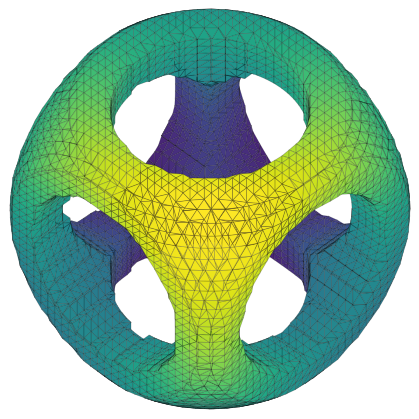

In [23]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import meshio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", theta=45.0, phi=45.0, scale=1.5)
mesh = meshio.read("out.stl")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("viridis"), edgecolors=(0, 0, 0, 0.25))
plt.show()

In [24]:
from sdf import *

f = intersection(sphere(1), box(1.5))
c = cylinder(0.5)
X = [1.0, 0.0, 0.0]
Y = [0.0, 1.0, 0.0]
Z = [0.0, 0.0, 1.0]
cross = union(orient(c, X), orient(c, Y), orient(c, Z))
f = difference(f, cross)

f.save("out2.stl", step=0.05)

min -0.84543, -0.84543, -0.84543
max 0.845431, 0.845431, 0.845431
step 0.05, 0.05, 0.05
42875 samples in 8 batches with 12 workers
  100% (8 of 8) [##############################] 0:00:00 0:00:00    
1 skipped, 6 empty, 1 nonempty
12820 triangles in 0.0534065 seconds


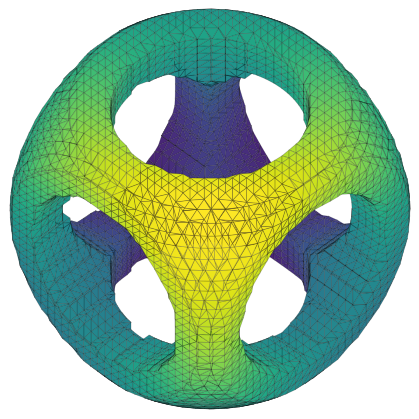

In [25]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import meshio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", theta=45.0, phi=45.0, scale=1.5)
mesh = meshio.read("out2.stl")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("viridis"), edgecolors=(0, 0, 0, 0.25))
plt.show()

In [26]:
from sdf import *

f = difference(
    intersection(
        sphere(1), 
        box(1.5)
    ), 
    union(
        orient(
            cylinder(0.5), 
            [1.0, 0.0, 0.0]
        ), 
        orient(
            cylinder(0.5), 
            [0.0, 1.0, 0.0]
        ), 
        orient(
            cylinder(0.5), 
            [0.0, 0.0, 1.0]
        )
    )
)

f.save("out3.stl", step=0.05)

min -0.84543, -0.84543, -0.84543
max 0.845431, 0.845431, 0.845431
step 0.05, 0.05, 0.05
42875 samples in 8 batches with 12 workers
  100% (8 of 8) [##############################] 0:00:00 0:00:00    
1 skipped, 6 empty, 1 nonempty
12820 triangles in 0.0472095 seconds


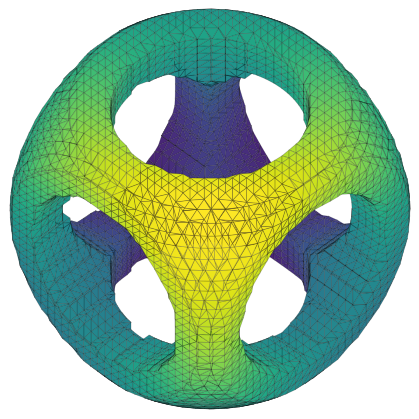

In [27]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import meshio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", theta=45.0, phi=45.0, scale=1.5)
mesh = meshio.read("out3.stl")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("viridis"), edgecolors=(0, 0, 0, 0.25))
plt.show()

In [28]:
# Dunno about JSON, that would be (very) verbose ...
# Look at the OpenScad (CSG subset) format?
# Do XML?

difference(
    intersection(
        sphere(1), 
        box(1.5)
    ), 
    union(
        orient(
            cylinder(0.5), 
            [1.0, 0.0, 0.0]
        ), 
        orient(
            cylinder(0.5), 
            [0.0, 1.0, 0.0]
        ), 
        orient(
            cylinder(0.5), 
            [0.0, 0.0, 1.0]
        )
    )
)

### Binary STL

- [ ] Discover that `out.stl` is not ASCII text, but binary
- [ ] Read about binary STL online
- [ ] Ask if there is anything useful in the first 80 bytes (header)
- [ ] Read the number of triangles `n` (hint to `numpy.fromfile`); check that works out.
- [ ] Check that the lenth of the binary data checks out with this count and the spec
- [ ] Read the numeric data as a `(n, 12)` array of `float32`
- [ ] Extract from this array the `normals` (shape `(n, 3)`) and `vertices` (shape `(n, 3, 3)`) arrays.

In [29]:
with open("out.stl", mode="rb") as file:
    print(file.read(200))

b"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x142\x00\x00\xae\xa1Q\xbf/M\x0e\xbf#y\x12\xbe\x81\xd4>\xbf\xe8:%\xbf\xe5\xcf(\xbe\x81\xd4>\xbf\x81\x82&\xbf\x9e\xeb\x14\xbe\xe2\xb2?\xbf\xe8:%\xbf\x9e\xeb\x14\xbe\x00\x00\x0ce^\xbf\xf1^\xfd\xbe$|\xa7\xbc\x81\xd4>\xbf\xabH'\xbf\xd6p\xc3\xbd\x00\x00@\xbf\xe8:%\xbf\xd6p\xc3\xbd\xe2\xb2?\xbf\xe8:%\xbf\x9e\xeb\x14\xbe\x00\x00\x03\xb0S\xbfw\xb2\x0f\xbf\x83\n\x0b\xbd\x81\xd4>\xbf"


In [30]:
with open("out.stl", mode="rb") as file:
    header = file.read(80)
header == 80 * bytes([0])

True

In [31]:
import numpy as np
with open("out.stl", mode="rb") as file:
    n = np.fromfile(file, dtype=np.uint32, count=1, offset=80)
n[0]

np.uint32(12820)

In [32]:
# Alternative (better): read header, then the offset not necessary
# TODO: warn about "cursor" and offset with numpy.fromfile for something partially read
# Suggest a little experiment maybe to discover what's going on.
import numpy as np
with open("out.stl", mode="rb") as file:
    header = file.read(80)
    n = np.fromfile(file, dtype=np.uint32, count=1)[0]
print(n)

12820


In [33]:
import numpy as np
with open("out.stl", mode="rb") as file:
    data = file.read()
    print(len(data))
    print(80 + 4 + n * (4*4*3 + 2))

641084
641084


In [34]:
import numpy as np
with open("out.stl", mode="rb") as file:
    header = file.read(80)
    n = np.fromfile(file, dtype=np.uint32, count=1)[0]
    data = np.empty((n, 4 * 3), dtype=np.float32)
    for i in range(n):
        data[i] = np.fromfile(file, dtype=np.float32, count=12)
        _ = file.read(2)

In [35]:
normals = data[:,0::4]
x = data[:,1::4]
y = data[:,2::4]
z = data[:,3::4]
vertices = np.stack((x, y, z), axis=1)
np.shape(vertices)

(12820, 3, 3)

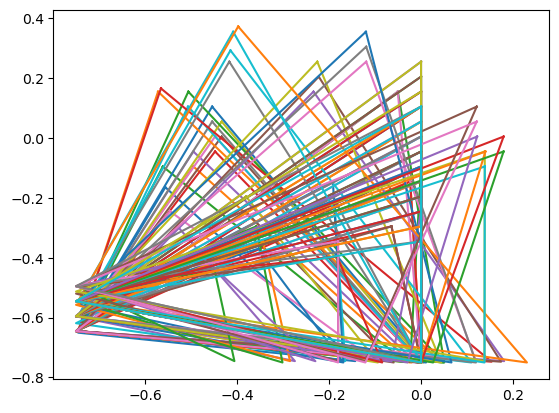

In [36]:
# Something fishy here, maybe the data computation above (the stacking?),
# maybe something else. And VERY SLOW of course.
import matplotlib.pyplot as plt
fig = plt.figure()
for vs in vertices[:100]:
    x = [v[0] for v in vs]
    y = [v[1] for v in vs]
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y)

### Matplotlib 3D first try

Mmmm there is some `meshio` stuff here. Too complex actually, lead the students to make their own micro-matplotlib3d.

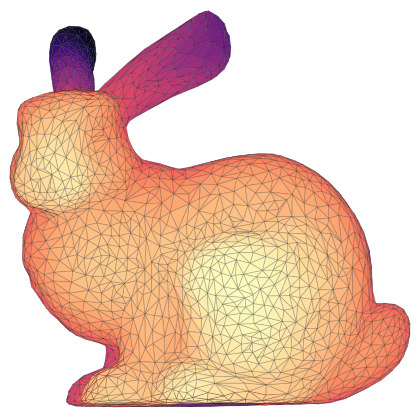

In [37]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import meshio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", scale=2)
mesh = meshio.read("data/bunny.obj")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("magma"),  edgecolors=(0,0,0,0.25))
plt.show()


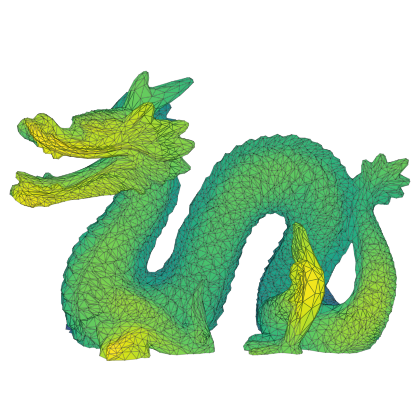

In [38]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import meshio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", theta=75.0, scale=2.0)
mesh = meshio.read("data/dragon.stl")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("viridis"), edgecolors=(0,0,0,0.25))
plt.show()

## JCAD

- [ ] Get the basic (provided) box, sphere, (capped) cylinder jcad models and build a object for each of them.
- [ ] Automate the conversion with a jcad_to_sdf function that works for each of these primitives. Make sure that the function still works if you change the length/width/height parameters of the box, the radius of the sphere and the radius and
height of the cylinder.
- [ ] Improve your function so that it also supports the angle 1, 2 and 3 of the sphere and the angle of the cylinder. (Make it optional or get rid of this, we don't care)
- [ ] Extend your function so that all the placements parameters are also supported.
- [ ] Extend your function so that it can work with several primitive objects. You will keep in the sdf object only the (union of) the objects that are visible in the jcad model.
- [ ] Make your function work with complex models based on union, intersection and differences of primitive objects.

"Validation":

- [ ] Reproduce the canonical CSG example with JCAD, save it as "data/csg.jcad"
- [ ] Output "the" (or the union of) the objects that are visible in the JCAD GUI
- [ ] ...

TODO: present this upside down: start with the design of the canonical example in jcad, then work your way up in the conversion.

In [116]:
def flat_jcad_to_sdf(jcad):
    shapes = jcad["objects"]
    parts = {}
    for shape in shapes:
        kind = shape["shape"]
        params = shape["parameters"]
        if kind == "Part::Box":
            length = params["Length"]
            width = params["Width"]
            height = params["Height"]
            part = sdf.box((length, width, height)).translate((0.5*length, 0.5*width, 0.5*height))
        elif kind == "Part::Sphere":
            radius = params["Radius"]
            part = sdf.sphere(radius=radius)
        elif kind == "Part::Cylinder":
            height = params["Height"]
            radius = params["Radius"]
            part = sdf.capped_cylinder([0, 0, 0], [0, 0, height], radius)
        elif kind == "Part::MultiFuse":
            shapes = [parts[name] for name in params["Shapes"]]
            part = sdf.union(*shapes)
        elif kind == "Part::MultiCommon":
            shapes = [parts[name] for name in params["Shapes"]]
            part = sdf.intersection(*shapes)
        elif kind == "Part::Cut":
            base = parts[params["Base"]]
            tool = parts[params["Tool"]]
            part = sdf.difference(base, tool)
        placement = params["Placement"]
        offset = placement["Position"]
        rotation_axis = placement["Axis"]
        rotation_angle = placement["Angle"] / 180.0 * np.pi
        part = part.rotate(rotation_angle, rotation_axis).translate(offset)
        name = shape["name"]
        parts[name] = part
    visibility_map = jcad["options"]["guidata"]
    include_parts = [parts[name] for name, spec in visibility_map.items() if spec["visibility"] == True]
    return sdf.union(*include_parts)

In [121]:
with open("data/jcad/csg.jcad", mode="rt", encoding="utf-8") as file:
    jcad_model = json.load(file)
sdf_model = flat_jcad_to_sdf(jcad_model)
sdf_model.save("out.stl", step=0.05)

min -0.84543, -0.84543, -0.84543
max 0.845431, 0.845431, 0.845431
step 0.05, 0.05, 0.05
42875 samples in 8 batches with 12 workers
  100% (8 of 8) [##############################] 0:00:00 0:00:00    
1 skipped, 6 empty, 1 nonempty
12820 triangles in 0.110837 seconds


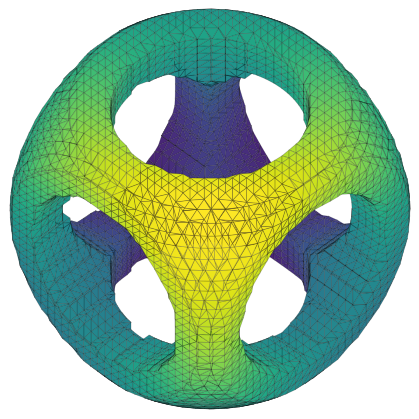

In [122]:
import numpy as np
from mpl3d import glm
from mpl3d.mesh import Mesh
from mpl3d.camera import Camera
import meshio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4,4))
ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1)
ax.axis("off")

camera = Camera("ortho", theta=45.0, phi=45.0, scale=1.5)
mesh = meshio.read("out.stl")
vertices = mesh.points
faces = mesh.cells[0].data
vertices = glm.fit_unit_cube(vertices)
mesh = Mesh(ax, camera.transform, vertices, faces,
            cmap=plt.get_cmap("viridis"), edgecolors=(0, 0, 0, 0.25))
plt.show()

In [54]:
model

{'objects': [{'shape': 'Part::Sphere',
   'visible': True,
   'parameters': {'Angle1': -90.0,
    'Radius': 1.0,
    'Angle2': 90.0,
    'Angle3': 360.0,
    'Placement': {'Angle': 0.0,
     'Position': [0.0, 0.0, 0.0],
     'Axis': [0.0, 0.0, 1.0]}},
   'name': 'Sphere 1',
   'shapeMetadata': {'matrixOfInertia': [[-6.149371676196115e-33,
      -3.6020088952748003e-34,
      1.6755160819145567],
     [1.6755160819145563, 9.961007110492846e-17, -6.149371676196115e-33],
     [9.961007110492846e-17, 1.6755160819145567, -3.6020088952748003e-34]],
    'mass': 4.188790204786391,
    'centerOfMass': [-5.886225973305397e-17,
     8.586164334772796e-18,
     2.6020852139652103e-18]}},
  {'shapeMetadata': {'centerOfMass': [0.0, 0.0, 0.0],
    'matrixOfInertia': [[0.0, 0.0, 1.2656250000000009],
     [1.2656250000000009, 0.0, 0.0],
     [0.0, 1.265625, 0.0]],
    'mass': 3.375},
   'visible': True,
   'name': 'Box 1',
   'shape': 'Part::Box',
   'parameters': {'Length': 1.5,
    'Placement': {'Ang